O seguinte projeto tem como objetivo fazer uma análise de risco de crédito, que consiste na possibilidade de perdas financeiras devido a inadimplência por parte do tomador do crédito.

Para realizar o projeto utilizamos um Dataset com aplicações para crédito onde cada linha representa diversas características da aplicação, desde informações bancárias até o formato de acesso da aplicação, entre elas, uma coluna que classifica se a operação foi considerada inadimplência ou não.

Bibliotecas:

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report

Dataset:

In [87]:
data = pd.read_csv('acquisition_train.csv')
data_backup = data.copy()

# Informações básicas do dataset:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ids                                               45000 non-null  object 
 1   target_default                                    41741 non-null  object 
 2   score_1                                           44438 non-null  object 
 3   score_2                                           44438 non-null  object 
 4   score_3                                           44438 non-null  float64
 5   score_4                                           45000 non-null  float64
 6   score_5                                           45000 non-null  float64
 7   score_6                                           45000 non-null  float64
 8   risk_rate                                         44438 non-null  float64
 9   last_amount_borro

* Limpeza dos dados e Análise exploratória:

In [88]:
# Excluindo linhas duplicadas:

data.drop_duplicates()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,...,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,...,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,...,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,...,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,...,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,...,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,696cb747-1159-0a29-6731-8c52c6c42f5d,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,280.0,96.379531,0.416693,103.667082,0.17,14766.42,...,730,"(-22.486891256430695, -44.909010639017616)",Facebook,768-5074915,73417.0,BR-GO,52148,"{'tags': ['n1', 'n7', 'n4', 'n0']}",Mozilla/5.0 (Linux; Android 6.0.1; SM-G920V Bu...,NaN
44996,92cd9b1a-9a8e-43ad-5d96-8e999128b472,False,smzX0nxh5QlePvtVf6EAeg==,vJyc9xom9v7hwFMPTIpmKw==,370.0,96.124977,0.692196,97.977973,0.27,NaN,...,28,"(-12.881449687799003, -46.43545330884514)",Waiting-list,772-3517810,26246.0,BR-RO,46084,"{'tags': ['n11', 'n5', 'n12']}",Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...,NaN
44997,febdd174-cf18-0be1-feb8-38399dd67d9e,False,e4NYDor1NOw6XKGE60AWFw==,ky19q4V1ZqgL3jnHX0wKDw==,280.0,102.377780,0.530938,93.687747,0.30,NaN,...,940,"(-23.888982131800983, -50.645313285616645)",Waiting-list,334-9885724,101252.0,BR-SP,30570,"{'tags': ['dfa', 'c55', 'pro+aty']}",Mozilla/5.0 (Linux; Android 5.0.2; LG-V410/V41...,NaN
44998,a0a5a872-6165-b939-b711-37d045a0b5a8,True,smzX0nxh5QlePvtVf6EAeg==,6J1ZMTzN5GKHXnhM4J1JbA==,240.0,100.476090,0.214697,86.759074,0.37,NaN,...,459,"(-5.14769885524928, -37.98386842511541)",Instagram,238-9568414,129844.0,BR-SP,12742,"{'tags': ['n9', 'n2']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN


In [89]:
# Porcentagem de dados faltantes: 

data_fal = (data.isnull().sum()/data.shape[0])*100

print(data_fal[data_fal > 0].sort_values(ascending=False))

target_fraud                                        96.617778
last_amount_borrowed                                66.568889
last_borrowed_in_months                             66.568889
ok_since                                            58.988889
external_data_provider_credit_checks_last_2_year    50.284444
external_data_provider_credit_checks_last_year      33.608889
credit_limit                                        30.666667
n_issues                                            25.653333
facebook_profile                                     9.906667
marketing_channel                                    7.951111
job_name                                             7.413333
target_default                                       7.242222
external_data_provider_email_seen_before             4.962222
lat_lon                                              3.028889
user_agent                                           1.604444
n_bankruptcies                                       1.548889
n_defaul

In [90]:
# Criando um novo dataset contendo as colunas com menos de 50% de dados faltantes:

index = data_fal[data_fal < 50.0].index

data = data[index]

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 38 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   ids                                              45000 non-null  object 
 1   target_default                                   41741 non-null  object 
 2   score_1                                          44438 non-null  object 
 3   score_2                                          44438 non-null  object 
 4   score_3                                          44438 non-null  float64
 5   score_4                                          45000 non-null  float64
 6   score_5                                          45000 non-null  float64
 7   score_6                                          45000 non-null  float64
 8   risk_rate                                        44438 non-null  float64
 9   credit_limit                

In [91]:
# Verificando informações das variáveis numéricas:

data.describe()

c:\Users\Daniels\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,score_3,score_4,score_5,score_6,risk_rate,credit_limit,income,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,31200.000000,4.443800e+04,44303.000000,44426.000000,44438.000000,33456.000000,45000.000000,45000.000000,29876.000000,42767.000000,45000.000000,45000.00,45000.000000
mean,347.983258,100.006797,0.500037,99.925228,0.296717,34381.951154,7.160739e+04,0.076270,0.004569,10.696701,11.068119,247.537000,1.501067,0.503381,12.534781,500.399800,inf,33923.514844
std,110.429165,3.178080,0.288326,10.016549,0.101933,36586.982218,5.185897e+04,0.274052,0.079400,4.592463,4.595501,146.118398,1.114941,0.499997,126.530487,287.968873,NaN,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-999.000000,0.000000,403.00,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,10000.000000,4.501078e+04,0.000000,0.000000,7.000000,8.000000,120.000000,1.000000,0.000000,11.000000,252.000000,50948.25,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,25647.000000,6.126676e+04,0.000000,0.000000,10.000000,10.000000,248.000000,2.000000,1.000000,27.000000,503.000000,101779.00,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,47086.750000,8.601923e+04,0.000000,0.000000,13.000000,14.000000,375.000000,2.000000,1.000000,43.000000,747.000000,151337.25,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,448269.000000,5.000028e+06,5.000000,5.000000,49.000000,49.000000,500.000000,3.000000,1.000000,59.000000,1000.000000,inf,56000.000000


'reported_income' apresenta valores inconsistentes de média e valor máximo.
'external_data_provider_email_seen_before' aapresenta valor mínimo inconsistente.

In [92]:
# Removendo linhas com valor (inf) na coluna [reported_income];

data = data[data['reported_income'] != np.inf]

# Substituindo valores negativos da coluna [external_data_provider_email_seen_before] por valores nulos:

data.loc[data['external_data_provider_email_seen_before'] < 0] = np.nan

In [93]:
# Obtendo os índices referentes as colunas com variáveis numéricas e categóricas:

data_n = data.select_dtypes(exclude='object')
index_num = data_n.columns

data_c = data.select_dtypes('object')
index_cat = data_c.columns

print(f'Número de variáveis numéricas: {data[index_num].shape[1]} \n Número de variáveis categóricas: {data[index_cat].shape[1]}')

Número de variáveis numéricas: 18 
 Número de variáveis categóricas: 20


In [94]:
# Número de valores únicos para variáveis categóricas (cardinalidade):

print(data[index_cat].nunique().sort_values(ascending=False))

ids                                  43642
profile_phone_number                 43642
application_time_applied             34708
external_data_provider_first_name    32185
job_name                             31381
profile_tags                         25431
lat_lon                              22066
reason                               14476
zip                                    822
user_agent                             297
state                                   50
score_2                                 35
shipping_state                          25
marketing_channel                        9
score_1                                  7
email                                    6
real_state                               5
target_default                           2
facebook_profile                         2
channel                                  1
dtype: int64


Variáveis categóricas com alta cardinalidade tendem a ser pouco eficientes para o treino de modelos.

In [95]:
# Obtendo uma lista com variáveis de cardinalidade maior que 250:

list = []

for i in index_cat:
    if data[i].nunique() > 250:
        list.append(i)

print(list)

['ids', 'reason', 'zip', 'job_name', 'application_time_applied', 'external_data_provider_first_name', 'lat_lon', 'profile_phone_number', 'profile_tags', 'user_agent']


Podemos excluir estas colunas do dataset, com exceção da coluna 'application_time_applied' que contém informações dos horários das aplicações.

Estes dados podem conter informações relevantes sobre possíveis inadimplentes.

In [96]:
list.remove('application_time_applied')

data.drop(labels=list, axis=1, inplace=True)

In [97]:
# Limpando alguns dados categóricos:

data['email'] = data['email'].replace('hotmaill.com', 'hotmail.com')
data['email'] = data['email'].replace('gmaill.com', 'gmail.com')

data['facebook_profile'] = data['facebook_profile'].replace(np.nan, False)
data['facebook_profile'] = data['facebook_profile'].map({True:1, False:0})

data['shipping_state'] = data['shipping_state'].str[-2:]

C:\Users\Daniels\AppData\Local\Temp\ipykernel_3780\4074064706.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['facebook_profile'] = data['facebook_profile'].replace(np.nan, False)


In [98]:
# Escrevendo uma função para substituir os valores faltantes de uma coluna por valores
# presentes na coluna na mesma proporção de ocorrência

def preencher_proporção(col):
    """ Preenche valores ausentes na mesma proporção dos valores presentes

    Recebe uma coluna e retorna a coluna com os valores faltantes preenchidos
    na proporção dos valores existentes."""

    # gerando o dicionário com valores únicos e sua porcentagem:
    por = col.value_counts(normalize=True).to_dict()

    # transformando as chaves e valores do dicionário em uma lista:
    percent = [por[key] for key in por]
    lab = [key for key in por]

    # utilizando as listas para preencher os valores nulos na proporção correta:
    s = pd.Series(np.random.choice(lab, p=percent, size=col.isnull().sum()))
    col = col.fillna(s)

    # verificando se todos os valores ausentes foram preenchidos e
    # preenchendo os que não tiverem sido:
    if len(col.isnull()) > 0:
        col.fillna(value=max(por, key=por.get), inplace=True, axis=0)
    
    return col

In [99]:
# Iterando as colunas do dataframe aplicando a função acima em variáveis categóricas e
# substiuindo valores numéricos faltantes pela mediana:

for col in data.iloc[:,1:].columns.tolist():
    if data[col].dtypes == 'O':
        data[col] = preencher_proporção(data[col])
    else:
        data[col] = data[col].fillna(value=data[col].median(), axis=0)

data.isnull().sum()

target_default                                     4445
score_1                                               0
score_2                                               0
score_3                                               0
score_4                                               0
score_5                                               0
score_6                                               0
risk_rate                                             0
credit_limit                                          0
income                                                0
facebook_profile                                      0
state                                                 0
channel                                               0
real_state                                            0
n_bankruptcies                                        0
n_defaulted_loans                                     0
n_accounts                                            0
n_issues                                        

In [100]:
# Removendo as linhas cuja variável alvo (target_default) sejam nulas:

data = data.dropna(subset=['target_default'])

Por fim, após limparmos os dados, seguímos com o seguinte dataset:

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40488 entries, 0 to 44999
Data columns (total 29 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   target_default                                   40488 non-null  object 
 1   score_1                                          40488 non-null  object 
 2   score_2                                          40488 non-null  object 
 3   score_3                                          40488 non-null  float64
 4   score_4                                          40488 non-null  float64
 5   score_5                                          40488 non-null  float64
 6   score_6                                          40488 non-null  float64
 7   risk_rate                                        40488 non-null  float64
 8   credit_limit                                     40488 non-null  float64
 9   income                           

* Análise explanatória e Feature engeneering:

Text(0.5, 1.0, 'Índice de inadimplência por Estado')

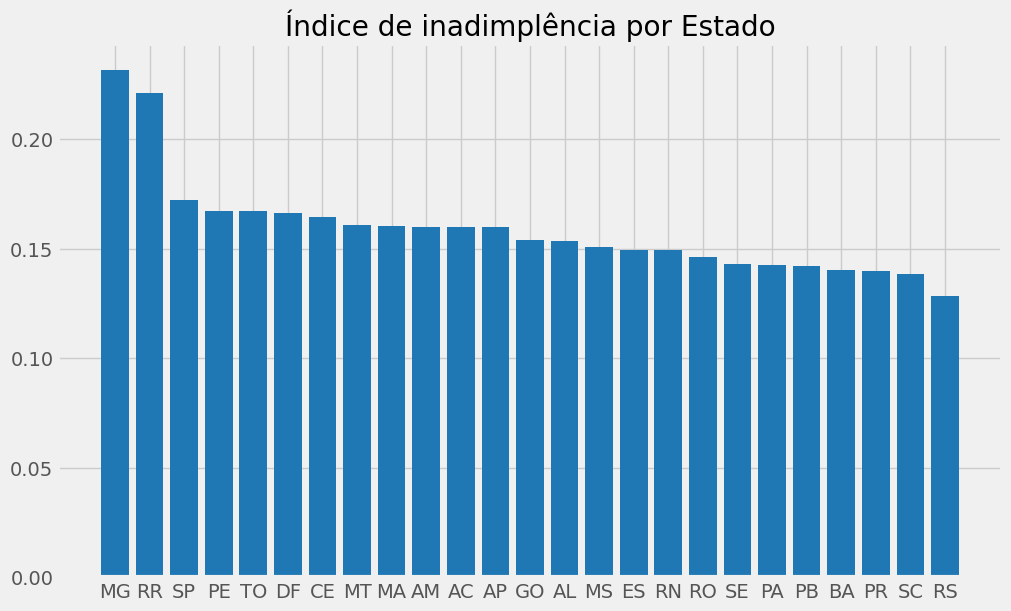

In [102]:
# Visualizando a relação entre a variável alvo com algumas outras variáveis:

g1 = data.groupby('shipping_state')['target_default'].mean().sort_values(ascending=False)

plt.style.use('fivethirtyeight')
plt.figure(figsize=[10,6], layout='constrained')
plt.bar(g1.index, g1, width=0.8, linewidth=0.9, color='tab:blue')
plt.title('Índice de inadimplência por Estado')


# Com a figura a seguir podemos observar o impacto de cada Estado na inadimplência.
# Sendo os Estados do Minas Gerais e Roraima com maior índice de inadimplência.


Os estados de Minas Gerais (MG) e Roraima (RR) apresetam os maiores índices de inadimplência.

Text(0.5, 1.0, 'Índice de inadimplência por Estado')

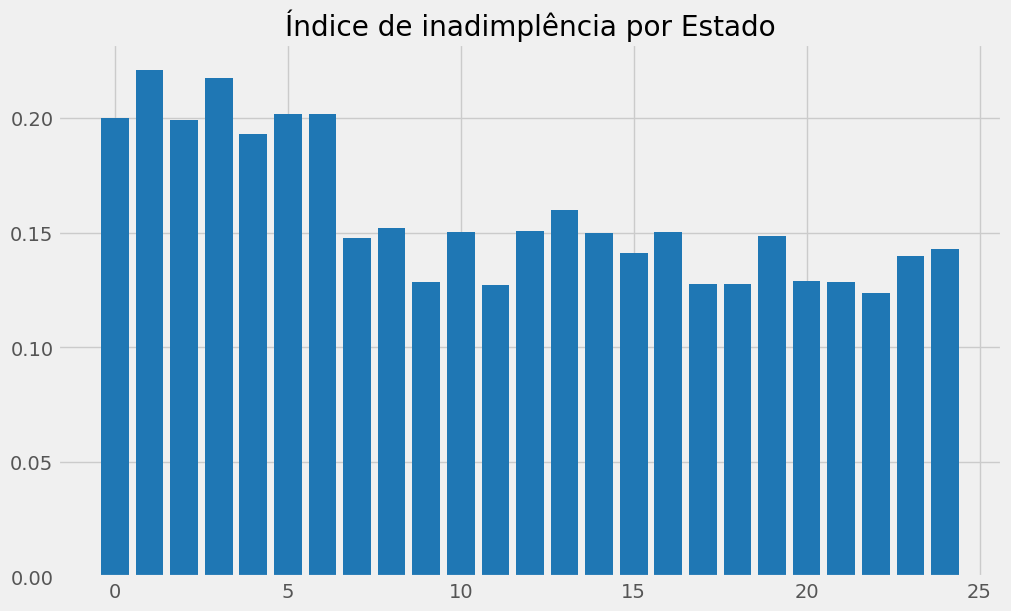

In [103]:
# Removendo minutos e segundos de ['application_time_applied']

data['application_time_applied'] = data['application_time_applied'].str[:2].astype(int)

g2 = data.groupby('application_time_applied')['target_default'].mean().sort_values(ascending=False)

plt.style.use('fivethirtyeight')
plt.figure(figsize=[10,6], layout='constrained')
plt.bar(g2.index, g2, width=0.8, linewidth=0.9, color='tab:blue')
plt.title('Índice de inadimplência por Estado')

Aplicações realizadas de madrugada (entre meia noite e 6 da manhã) apresentam maior índice de inadimplência.

In [104]:
# Criando uma nova coluna no dataset representando aplicações de madrugada:

data['madrugada'] = data['application_time_applied'].apply(lambda x: 1 if x<=6 else 0)

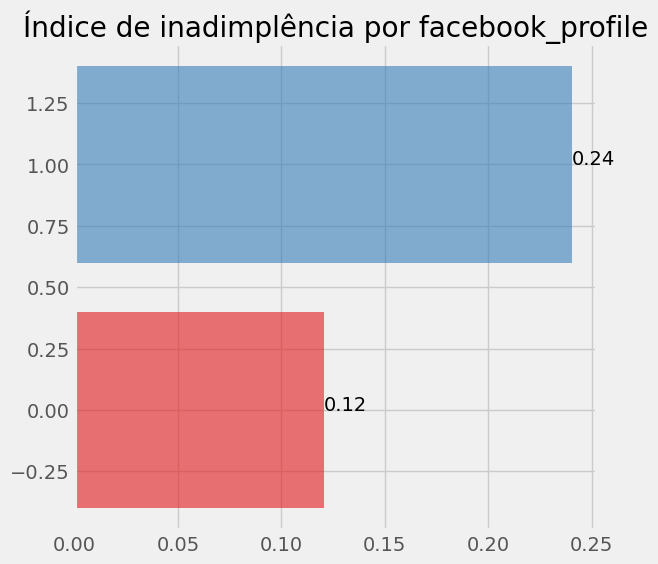

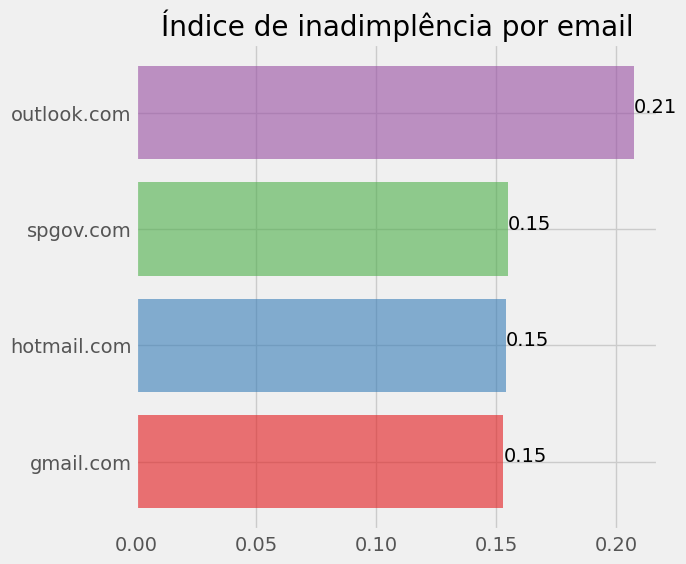

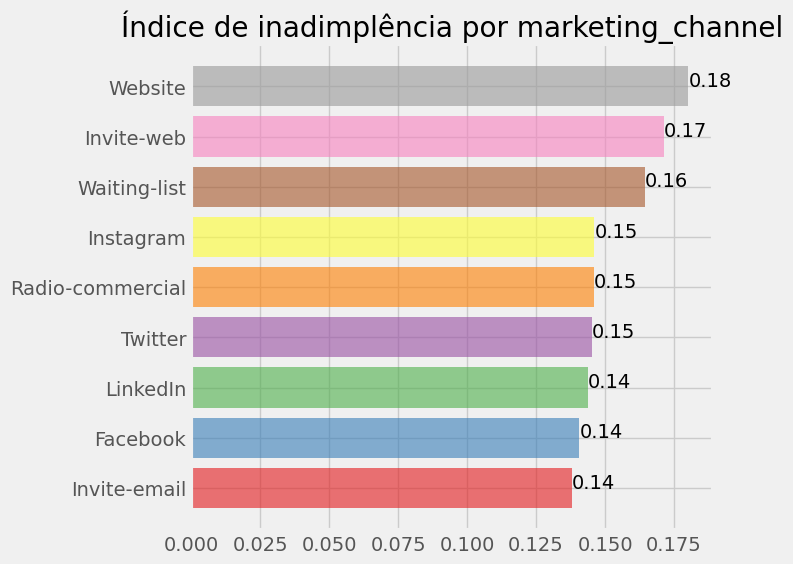

In [105]:
# Visualizando a relação de outras variáveis categóricas com a variável alvo:

cat = ['facebook_profile', 'email', 'marketing_channel']

for i in cat:
    gi = data.groupby(i)['target_default'].mean().sort_values(ascending=True)

    plt.style.use('fivethirtyeight')
    plt.figure(figsize=[6,6])
    plt.barh(gi.index, gi, color=sns.color_palette('Set1'), alpha=0.6)
    for index, value in enumerate(gi): 
        plt.text(value, index, 
             str(round(value, 2)))
    plt.title(f'Índice de inadimplência por {i}')

[facebook_profile] - Podemos ver uma maior chance de inadimplência para aplicações
com perfil no Facebook.

[mail] - aplicações feitas com @outlook.com tem uma maior probabilidade de inadimplência. 

[marketing channel] - Índices são relativamente próximos para cada formato de aplicação.

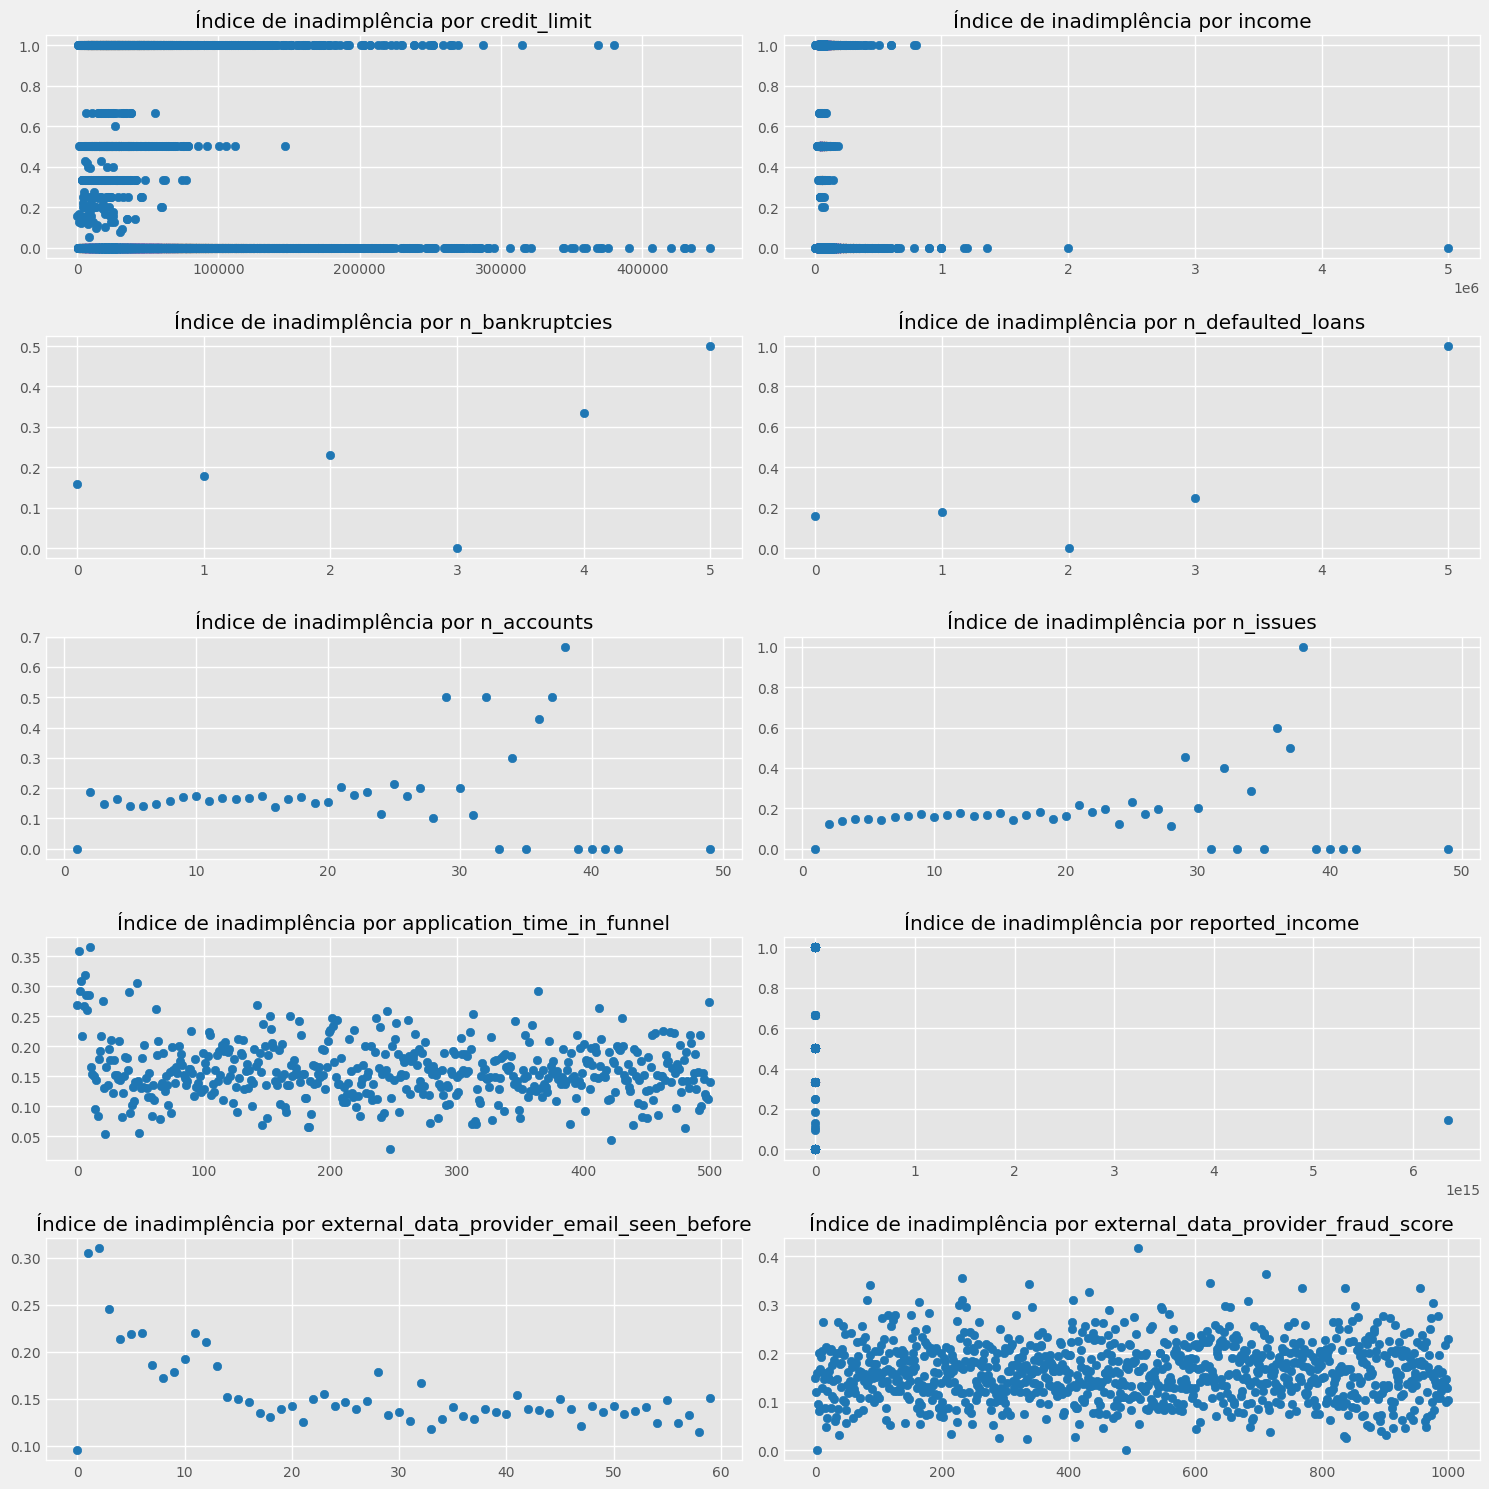

In [106]:
# Visualizando a relação de variáveis numéricas com a variável alvo:

num = ['credit_limit', 'income', 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts', 'n_issues',
    'application_time_in_funnel', 'reported_income', 'external_data_provider_email_seen_before',
    'external_data_provider_fraud_score']

fig = plt.figure(figsize=(15, 15))
plt.style.use('ggplot')

for j in range(len(num)):
    gj = data.groupby(num[j])['target_default'].mean()
    ax = fig.add_subplot(5, 2, j+1)
    ax.scatter(gj.index, gj, color='tab:blue')
    ax.set_title(f'Índice de inadimplência por {num[j]}')

plt.tight_layout()

Podemos ver uma relação aproximadamente crescente entre a probabilidade de inadimplência 
com [n_bankruptcies] e [n_defaulted_loans]:

[n_bankruptcies] - implicam em uma maior chance de inadimplência para maior número de
falências

[n_defaulted_loans] - implicam em uma maior chance de inadimplência para maior número de
"aplicações padronizadas"

 Relação relativamente constante em um certo intervalo  com uma descontinuidade para valores
próximos a 40, onde a probabilidade de inadimplência aparenta ser nula para as variáveis [n_accounts] e [n_issues]

[n_accounts] e [n_issues] - implicam em uma baixíssima chance de inadimplência após um 
certa quantidade de contas abertas e problemas registrados

Podemos observar uma relação que decresce exponencialmente para valores maiores que zero
para a variável [external_data_provider_email_seen_before]

In [107]:
# Convertendo a coluna ['application_time_applied'] para valores numéricos:

data['application_time_applied'] = pd.to_numeric(data['application_time_applied'])

In [108]:
# Criando uma nova lista com variáveis caegóricas, removendo a variável alvo:

list_enc = data.select_dtypes('object').columns.tolist()

list_enc.remove('target_default')


In [109]:
# Tratando os dados categóricos com One-Hot-Encoding:

data_enc = pd.get_dummies(data[list_enc], dtype=int)


In [110]:
# Concatenando os dummies das variáveis categóricas com dataset:

X = pd.concat([data, data_enc], axis=1)

# Excluindo as colunas das variáveis categóricas:

X = X.drop(columns=list_enc, axis=1)

In [111]:
# Separando a variável alvo:

y = X['target_default'].astype(int)

In [112]:
# Separando o conjunto de dados para treinar os modelos:

X = X.drop('target_default', axis=1)

X_train, X_test, y_train, y_teste = train_test_split(X,y)

# Transformando os dados para otimizar a performance do modelo:

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

* Machine Learning:

In [113]:
# A seguir vamos utilizar 4 modelos (RandomForest Classifier, Logistic Regression,
# DecisionTree Classifier e XGB Classifier)

RFC = cross_validate(RandomForestClassifier(), X_train_s, y_train, scoring=['accuracy', 'precision', 'roc_auc'])

LR = cross_validate(LogisticRegression(), X_train_s, y_train, scoring=['accuracy', 'precision', 'roc_auc'])

DTC = cross_validate(DecisionTreeClassifier(), X_train_s, y_train, scoring=['accuracy', 'precision', 'roc_auc'])

XGB = cross_validate(XGBClassifier(), X_train_s, y_train, scoring=['accuracy', 'precision', 'roc_auc'])

In [114]:
# Armazenando os resultados em um dataset:

resultados = pd.DataFrame({
    'label': ['accuracy', 'precision'],
    'Random Forest': [RFC['test_accuracy'].mean(), RFC['test_precision'].mean(), RFC['test_roc_auc'].mean()],
    'Logistic Regression': [LR['test_accuracy'].mean(), LR['test_precision'].mean(), LR['test_roc_auc'].mean()],
    'Decision Tree': [DTC['test_accuracy'].mean(), DTC['test_precision'].mean(), DTC['test_roc_auc'].mean()],
    'XGBoost': [XGB['test_accuracy'].mean(), XGB['test_precision'].mean(), XGB['test_roc_auc'].mean()]
}).set_index('label')

resultados.index.name=None
resultados = resultados.transpose()

resultados

ValueError: All arrays must be of the same length

O modelo de Random Forest Classifier aparenta ser o melhor modelo, sendo assim, será o escolhido para o modelo final.

* Tunning de Hiperparâmetros:

Optimizaremos o modelo tunando os seguintes parâmetros:
- criterion
- n_estimators
- max_depth
- min_samples_split
- min_samples_leaf

In [ ]:
# criterion

kfold = StratifiedKFold(n_splits=5, shuffle=True)

RF = RandomForestClassifier()

parametro = {'criterion': ['gini', 'entropy']}

search = GridSearchCV(RF, parametro, scoring='roc_auc', cv=kfold)
resultado = search.fit(X_train_s, y_train)

print(f'Melhor resultado: {resultado.best_score_} para parâmetro: {resultado.best_params_}')

Melhor resultado: 0.8398537853113103 para parâmetro: {'criterion': 'entropy'}


In [ ]:
# n_estimators

RF = RandomForestClassifier(criterion='entropy')

parametro = {'n_estimators': range(50,500,50)}

search = GridSearchCV(RF, parametro, scoring='roc_auc', cv=kfold)
resultado = search.fit(X_train_s, y_train)

print(f'Melhor resultado: {resultado.best_score_} para parâmetro: {resultado.best_params_}')

KeyboardInterrupt: 

In [ ]:
# max_depth

RF = RandomForestClassifier(criterion='entropy', n_estimators=400)

parametro = {'max_depth': range(1,10)}

search = GridSearchCV(RF, parametro, scoring='roc_auc', cv=kfold)
resultado = search.fit(X_train_s, y_train)

print(f'Melhor resultado: {resultado.best_score_} para parâmetro: {resultado.best_params_}')


In [ ]:
# min_samples_split

RF = RandomForestClassifier(criterion='entropy', n_estimators=400, max_depth=9)

parametro = {'min_samples_split': range(2,10,2)}

search = GridSearchCV(RF, parametro, scoring='roc_auc', cv=kfold)
resultado = search.fit(X_train_s, y_train)

print(f'Melhor resultado: {resultado.best_score_} para parâmetro: {resultado.best_params_}')

In [ ]:

# min_samples_leaf

RF = RandomForestClassifier(criterion='entropy', n_estimators=400, max_depth=9, min_samples_split=4)

parametro = {'min_samples_leaf': range(2,10,2)}

search = GridSearchCV(RF, parametro, scoring='roc_auc', cv=kfold)
resultado = search.fit(X_train_s, y_train)

print(f'Melhor resultado: {resultado.best_score_} para parâmetro: {resultado.best_params_}')

In [ ]:
# Construindo um novo modelo de RandomForest com os parâmetros ajustados:

RF_final = RandomForestClassifier(
           criterion='entropy', 
           n_estimators=400, 
           max_depth=9, 
           min_samples_split=4,
           min_samples_leaf=2)

#Treinando o modelo com os dados de treino

RF_final.fit(X_train_s, y_train)

# Calculando o erro médio absoluto para previsões feitas com os dados de treino
# e teste

mae_treino = mean_absolute_error(y_train, RF_final.predict(X_train_s))
mae_teste = mean_absolute_error(y_teste, RF_final.predict(X_test_s))

print('erro médio absoluto:')
print(f'treino: {mae_treino}')
print(f'teste: {mae_teste}')